# Point Cloud Registration using Standard ICP

In order to lower the uncertainty of calculations done with `py4dgeo`, point cloud registration should be performed to tightly align the point clouds. 

In this practical we will perform point cloud registration using a standard ICP implementation in `py4dgeo`. The workflow is introduced throughout this notebook. Also, make use of the [software documentation](https://py4dgeo.readthedocs.io/en/latest/pythonapi.html)!

`py4dgeo` supports point cloud registration in the following way:

* It allows you to apply arbitrary affine transformations to epochs and stores the transformation parameters as part of the epoch. 
* The transformation can be calculated directly in `py4dgeo` or it can be derived from an external tool and be applied to an epoch in `py4dgeo`. 

This notebook shows both ways of usage.

`py4dgeo` returns an affine transformation as a `3x4` matrix which contains the Rotation matrix $\mathbf{R}$ and the translation vector $\mathbf{t}$:

$$
\mathbf{T} = \left(\begin{array}{ccc}r_{11}&r_{12}&r_{13}&t_1\\r_{21}&r_{22}&r_{23}&t_2\\r_{31}&r_{32}&r_{33}&t_3\end{array}\right)
$$


Note: For the ICP to work, the two point clouds must already be roughly aligned.

## Data
We will use two TLS scans acquired at a rockfall site in Obergurgl, Austria in 2019 (epoch 1) and 2022 (epoch 2). We use only stable parts that for co-registration and later apply the estimated transformation to the full point cloud:
- `tls_rockfall_20190619_stable_parts.laz`: Stable parts of epoch 1 (used as reference).
- `tls_rockfall_20220921_shifted_stable_parts.laz`: Stable parts of epoch 2 (to be aligned).
- `tls_rockfall_20220921_shifted_full_pc.laz`: Full point cloud of epoch 2 (to be aligned).

## Loading data
First, we start by setting up the Python environment and data:

In [1]:
import py4dgeo
import numpy as np
import shutil
import requests
import tempfile
import zipfile
import os
import copy

# url for download of data
url = "https://heibox.uni-heidelberg.de/f/a045ce9e0c8d4f8583d4/?dl=1"

# path to subfolder with dataset used in this notebook
subdir_path = "test_data_icp"

# generate temporary directory for data
temp_dir = tempfile.mkdtemp()

try:
    # download data
    response = requests.get(url)
    response.raise_for_status()

    # store zip archive in temp dir
    zip_path = os.path.join(temp_dir, "test_data_icp.zip")
    print(zip_path)
    with open(zip_path, "wb") as zip_file:
        zip_file.write(response.content)

    # unpack zip archive in subfolder
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        file_list = [f for f in zip_ref.namelist() if f.startswith(subdir_path)]
        zip_ref.extractall(temp_dir, members=file_list)

    # specify data path
    data_path = os.path.abspath(os.path.join(temp_dir, subdir_path))
    print(data_path)

except requests.exceptions.RequestException as e:
    print(f"Failed to download data: {e}")
except zipfile.BadZipFile as e:
    print(f"Failed to unpack data: {e}")

# check if the specified path exists
if not os.path.isdir(data_path):
    print(f"ERROR: {data_path} does not exist")
    print(
        "Please specify the correct path to the data directory by replacing <path-to-data> above."
    )

epoch1_filepath = os.path.join(data_path, "tls_rockfall_20190619_reference_stableparts.laz")
epoch2_filepath = os.path.join(data_path, "tls_rockfall_20220921_shifted_stableparts.laz")

# Load the two epochs from LAZ files:
epoch1 = py4dgeo.read_from_las(epoch1_filepath)
epoch2 = py4dgeo.read_from_las(epoch1_filepath)

print(f"Epoch 1 stable parts point cloud read: {epoch1_filepath}")
print(f"Epoch 2 stable parts point cloud read: {epoch2_filepath}")

C:\Users\ep413\AppData\Local\Temp\tmpmiv9o949\test_data_icp.zip
C:\Users\ep413\AppData\Local\Temp\tmpmiv9o949\test_data_icp
[2023-12-04 14:43:52][INFO] Reading point cloud from file 'C:\Users\ep413\AppData\Local\Temp\tmpmiv9o949\test_data_icp\tls_rockfall_20190619_reference_stableparts.laz'
[2023-12-04 14:43:52][INFO] Reading point cloud from file 'C:\Users\ep413\AppData\Local\Temp\tmpmiv9o949\test_data_icp\tls_rockfall_20190619_reference_stableparts.laz'
Epoch 1 stable parts point cloud read: C:\Users\ep413\AppData\Local\Temp\tmpmiv9o949\test_data_icp\tls_rockfall_20190619_reference_stableparts.laz
Epoch 2 stable parts point cloud read: C:\Users\ep413\AppData\Local\Temp\tmpmiv9o949\test_data_icp\tls_rockfall_20220921_shifted_stableparts.laz


Let's have a look at the documentation of the py4dgeo ICP implementation:

In [2]:
?py4dgeo.iterative_closest_point

## Definition of reduction point
When calculating and applying transformations in `py4dgeo`, it is always possible to specify the *reduction point* $\mathbf{x_0}$. This allows shifting coordinates towards the origin before applying rotations - leading to a numerically robust operation. The algorithm for a transformation is:

$$
\mathbf{Tx} = \left(\mathbf{R}(\mathbf{x}-\mathbf{x_0})\right) + \mathbf{t} + \mathbf{x_0}
$$

Using a reduction point is highly recommended when working with large coordinates to avoid correlation of coordinates and overflow.

Since we are working with large global coordinates in this notebook, we will use a reduction point suitable for our dataset (working with your own data you might choose the coordinates of your first point in the point cloud / the center of gravity of the point cloud / etc.):

In [3]:
# Bounding box center of 2022 epoch (global coordinates)
red_poi = np.array([653530.316040,5191905.207520,2020.801025])

## Calculating transformation parameters in py4dgeo
Now we can estimate the transformation matrix in `py4dgeo` to align both epochs. We are decreasing the tolerance and increasing the maximum number of iterations (compared to the default) to ensure very precise results:

In [4]:
trafo = py4dgeo.iterative_closest_point(
    epoch1, epoch2, tolerance=0.00001, max_iterations=50
)

[2023-12-04 14:43:53][INFO] Building KDTree structure with leaf parameter 10


Let's have a look at the transformation matrix:

In [5]:
print(trafo)

[[ 1.00000000e+00  1.50445789e-16  2.58580461e-17 -8.14907253e-10]
 [ 1.42000767e-16  1.00000000e+00  4.73571586e-17  9.31322575e-10]
 [-4.41463059e-17  1.11313332e-16  1.00000000e+00 -5.48880053e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


We make a copy of `epoch2` before applying the transformation to be able to use it in a later step.

In [6]:
epoch2_stableparts_orig = copy.deepcopy(epoch2)

## Apply transformation
Now, we can use this transformation matrix to transform `epoch2`:

In [7]:
epoch2.transform(trafo)

The `Epoch` class records applied transformations and makes them available through the `transformation` property:

In [8]:
epoch2.transformation

[(array([[ 1.00000000e+00,  1.50445789e-16,  2.58580461e-17,
          -8.14907253e-10],
         [ 1.42000767e-16,  1.00000000e+00,  4.73571586e-17,
           9.31322575e-10],
         [-4.41463059e-17,  1.11313332e-16,  1.00000000e+00,
          -5.48880053e-10],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
           1.00000000e+00]]),
  array([0., 0., 0.]))]

We can save `epoch2` to a zip archive:

In [9]:
output_dir = os.path.join(data_path, "tls_rockfall_2022_registered_stable_parts.zip")
epoch2.save(output_dir)

[2023-12-04 14:44:00][INFO] Saving epoch to file 'C:\Users\ep413\AppData\Local\Temp\tmpmiv9o949\test_data_icp\tls_rockfall_2022_registered_stable_parts.zip'
[2023-12-04 14:44:02][INFO] Saving a file without normals.


We now can apply this transformation to the full point cloud of `epoch2`:

In [10]:
epoch2_full_pc = py4dgeo.read_from_las(os.path.join(data_path, "tls_rockfall_20220921_shifted.laz"))
epoch2_full_pc.transform(trafo)
epoch2_full_pc.save(os.path.join(data_path, "tls_rockfall_2022_registered_full_pc.zip"))

[2023-12-04 14:44:05][INFO] Reading point cloud from file 'C:\Users\ep413\AppData\Local\Temp\tmpmiv9o949\test_data_icp\tls_rockfall_20220921_shifted.laz'
[2023-12-04 14:44:07][INFO] Saving epoch to file 'C:\Users\ep413\AppData\Local\Temp\tmpmiv9o949\test_data_icp\tls_rockfall_2022_registered_full_pc.zip'
[2023-12-04 14:44:13][INFO] Saving a file without normals.


## Evaluate shift
Let's compare the coordinates of the registered shifted point cloud in stable parts to the original:

In [11]:
# import required module
from scipy.spatial import KDTree

# build kd-tree from 3D coordinates
tree_orig = KDTree(epoch2_stableparts_orig.cloud)

# query indices of nearest neighbors of registered coordinates
nn_dists = tree_orig.query(epoch2.cloud, k=1)

# obtain distances as first element in tuple returned by query above
distances = nn_dists[0]

print(f'Mean dist: {np.mean(distances):.3f} m')
print(f'Median dist: {np.median(distances):.3f} m')
print(f'Std.dev. of dists: {np.std(distances):.3f} m')

Mean dist: 0.000 m
Median dist: 0.000 m
Std.dev. of dists: 0.000 m


Visualize the result:

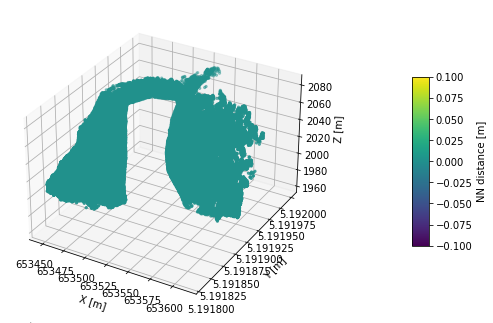

In [12]:
import matplotlib.pyplot as plt

# create a figure with 3D axis (two columns for different coloring)
fig, ax = plt.subplots(1,1,subplot_kw={"projection": "3d"},figsize=(7,5))

nth=100

# plot the point cloud colored by height (z values)
s = ax.scatter(epoch2.cloud[::nth,0], epoch2.cloud[::nth,1], epoch2.cloud[::nth,2], s=5,
                   c=distances[::nth])

# label axes and add title
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.set_zlabel('Z [m]')

# set initial view of 3D plot
#ax.view_init(elev=40., azim=230.)

# add a colorbar
fig.colorbar(s, shrink=.5, aspect=10, label='NN distance [m]', ax = ax, pad=0.2)

ax.set_aspect('equal')

# show the plot
plt.tight_layout()
plt.show()

## Applying external transformation parameters
Having calculated a transformation matrix externally, we can apply this to epoch 2 in `py4dgeo` by loading it as numpy array. In our case, we use a transformation matrix derived in CloudCompare. 

Note: In CloudCompare the transformation matrix was computed based on 2 point clouds which have been [globally shifted](https://www.cloudcompare.org/doc/wiki/index.php/Global_Shift_and_Scale) at import. After applying the ICP method in CloudCompare, we saved the resulting transformation matrix without their parameters being transformed to global coordinates (second transformation matrix CloudCompare prints in the console).

In [13]:
import json
epoch2_external_trafo = py4dgeo.read_from_las(os.path.join(data_path, "tls_rockfall_20220921_shifted.laz"))
with open(os.path.join(data_path, "external_trafo.json"), 'r') as json_file:
    trafo_data = json.load(json_file)
external_trafo = np.array(trafo_data)

[2023-12-04 14:44:32][INFO] Reading point cloud from file 'C:\Users\ep413\AppData\Local\Temp\tmpmiv9o949\test_data_icp\tls_rockfall_20220921_shifted.laz'


In [14]:
epoch2_external_trafo.transform(external_trafo, reduction_point=[653184.0, 5192220.0, 0])
epoch2_external_trafo.transformation
epoch2_external_trafo.save(os.path.join(data_path, "tls_rockfall_2022_registered_external_trafo.zip"))

[2023-12-04 14:44:34][INFO] Saving epoch to file 'C:\Users\ep413\AppData\Local\Temp\tmpmiv9o949\test_data_icp\tls_rockfall_2022_registered_external_trafo.zip'
[2023-12-04 14:44:40][INFO] Saving a file without normals.


## Available registration algorithms

Currently only standard point to point ICP is available, but other algorithms are currently being implemented:

In [15]:
?py4dgeo.iterative_closest_point